## 02 Overlap clusters MPP and LT - to help with naming

1) how much overlap in enriched genes between clusters  
2) differential proportion analysis - how similar are clusters between replicates for both MPPs and LTs 

from this paper https://elifesciences.org/articles/43882#s4  

done with this docker image:

docker run --rm -d --name test_eva -p 8883:8888 -e JUPYTER_ENABLE_LAB=YES -v /Users/efast/Documents/:/home/jovyan/work r_scanpy:vs5

In [1]:
#load some packages that are needed for plotting + computation

import math
from matplotlib import pyplot as plt
import pandas as pd
import scipy.stats as stats
import seaborn as sns
%matplotlib inline

In [2]:
LT = pd.read_csv('./write/all_LT_clusters.csv')
MPP = pd.read_csv('./write/all_MPP_clusters.csv')

In [3]:
# read in the list with enriched genes and calculate overlap of pairwise comparison between clusters

results_df_list =[]
results_df = pd.DataFrame()

for k in range(0, 12, 2):
    results_df_list =[]
    for i in range(0, 16, 2):
        mrg = pd.merge(LT, MPP, how='inner', left_on=LT.iloc[:,k], right_on=MPP.iloc[:,i])
        len_m = len(mrg)
        results_df_list.append(len_m)
    
    results_df_list = pd.Series(results_df_list)
    results_df = results_df.append(results_df_list, ignore_index=True)

In [4]:
results_df

,0,1,2,3,4,5,6,7
0,1.0,33.0,0.0,2.0,0.0,1.0,0.0,3.0
1,32.0,0.0,42.0,0.0,16.0,4.0,2.0,0.0
2,0.0,0.0,30.0,1.0,21.0,2.0,1.0,2.0
3,0.0,0.0,3.0,0.0,0.0,86.0,70.0,1.0
4,5.0,0.0,5.0,0.0,47.0,1.0,1.0,3.0
5,0.0,41.0,0.0,50.0,0.0,0.0,20.0,0.0


In [5]:
results_df.columns = ['Primed', 'Metabolism', 'Stem cell', 'Cell-cycle', 'Acute-Activation', 'Interferon', 'Interferon cell-cycle','Myeloid']
results_df.index = ['Metabolism', 'Quiescent', 'Activated', 'Interferon', 'Acute-Activation', 'Cell-cycle']

In [6]:
results_df

,Primed,Metabolism,Stem cell,Cell-cycle,Acute-Activation,Interferon,Interferon cell-cycle,Myeloid
Metabolism,1.0,33.0,0.0,2.0,0.0,1.0,0.0,3.0
Quiescent,32.0,0.0,42.0,0.0,16.0,4.0,2.0,0.0
Activated,0.0,0.0,30.0,1.0,21.0,2.0,1.0,2.0
Interferon,0.0,0.0,3.0,0.0,0.0,86.0,70.0,1.0
Acute-Activation,5.0,0.0,5.0,0.0,47.0,1.0,1.0,3.0
Cell-cycle,0.0,41.0,0.0,50.0,0.0,0.0,20.0,0.0


In [7]:
results_df_p = results_df/100
results_df_p

,Primed,Metabolism,Stem cell,Cell-cycle,Acute-Activation,Interferon,Interferon cell-cycle,Myeloid
Metabolism,0.01,0.33,0.00,0.02,0.00,0.01,0.00,0.03
Quiescent,0.32,0.00,0.42,0.00,0.16,0.04,0.02,0.00
Activated,0.00,0.00,0.30,0.01,0.21,0.02,0.01,0.02
Interferon,0.00,0.00,0.03,0.00,0.00,0.86,0.70,0.01
Acute-Activation,0.05,0.00,0.05,0.00,0.47,0.01,0.01,0.03
Cell-cycle,0.00,0.41,0.00,0.50,0.00,0.00,0.20,0.00


In [8]:
results_df_p.columns.tolist()

['Primed',
 'Metabolism',
 'Stem cell',
 'Cell-cycle',
 'Acute-Activation',
 'Interferon',
 'Interferon cell-cycle',
 'Myeloid']

In [9]:
results_df_p.index.tolist()

['Metabolism',
 'Quiescent',
 'Activated',
 'Interferon',
 'Acute-Activation',
 'Cell-cycle']

In [10]:
results_df_p = results_df_p[['Stem cell', 'Primed', 'Metabolism', 'Cell-cycle', 'Interferon cell-cycle', 
                 'Interferon', 'Acute-Activation','Myeloid']]
results_df_p = results_df_p.reindex(['Quiescent', 'Activated','Metabolism','Cell-cycle', 'Interferon',
                                     'Acute-Activation'])

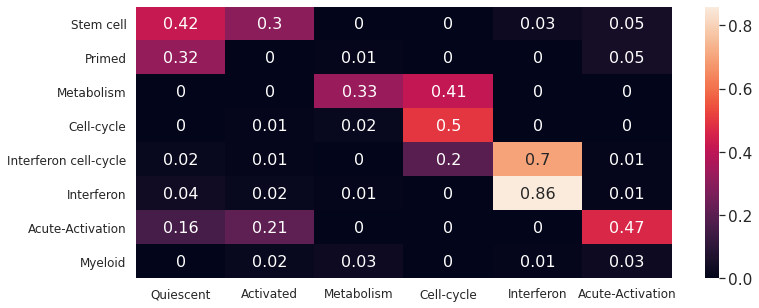

In [11]:
sns.set(font_scale=1.4)

plt.figure(figsize=(12,5))
sns.heatmap(results_df_p.T, annot=True, annot_kws={"size": 16})
plt.yticks(rotation=0, fontsize = 12) 
plt.xticks(rotation=-0, fontsize = 12)
plt.savefig("./figures/overlap_clusters_MPP_LT_all.pdf", dpi=300, bbox_inches='tight')

## 2) Differential proportion analysis

In [12]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import scipy.stats as stats

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

In [13]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

scanpy==1.4.5.1 anndata==0.7.1 umap==0.3.10 numpy==1.17.3 scipy==1.3.0 pandas==0.25.3 scikit-learn==0.22.2.post1 statsmodels==0.10.0 python-igraph==0.7.1 louvain==0.6.1


In [14]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
.libPaths(.libPaths()[c(3,2,1)])

# Load all the R libraries we will be using in the notebook
library(ggplot2)
library(plyr)

source("diffprop_functions.R");

## Comparison LT clusters

In [29]:
# read csvs, rename columns, merge and transpose
LT = pd.read_csv('./write/LT_cell_numbers.csv', index_col = 0)
LT = LT.T
LT

leiden,Metabolism,Quiescent,Activated,Interferon,Acute-Activation,Cell-cycle
GCSF,1204.0,937.0,780.0,21.0,0.0,42.0
ct,1865.0,1981.0,1556.0,40.0,0.0,79.0
dmPGE2,83.0,24.0,108.0,0.0,261.0,0.0
indo,1757.0,1816.0,1947.0,58.0,1.0,47.0
pIC,188.0,184.0,58.0,316.0,0.0,2.0


In [30]:
%%R -i LT
## Read in file of counts of cells in each population across conditions

obs.counts = as.matrix(LT)
print(obs.counts)

       Metabolism Quiescent Activated Interferon Acute.Activation Cell.cycle
GCSF         1204       937       780         21                0         42
ct           1865      1981      1556         40                0         79
dmPGE2         83        24       108          0              261          0
indo         1757      1816      1947         58                1         47
pIC           188       184        58        316                0          2


In [31]:
%%R

## Run an example using error (p) of 0.05 and with 100,000 iterations
tip.exp <- generateNull(obs.counts, n=100000, p=0.1);     # Generate the null distribution based on sampling

print(obs.counts/apply(obs.counts, 1, sum))

[1] 1000
[1] 2000
[1] 3000
[1] 4000
[1] 5000
[1] 6000
[1] 7000
[1] 8000
[1] 9000
[1] 10000
[1] 11000
[1] 12000
[1] 13000
[1] 14000
[1] 15000
[1] 16000
[1] 17000
[1] 18000
[1] 19000
[1] 20000
[1] 21000
[1] 22000
[1] 23000
[1] 24000
[1] 25000
[1] 26000
[1] 27000
[1] 28000
[1] 29000
[1] 30000
[1] 31000
[1] 32000
[1] 33000
[1] 34000
[1] 35000
[1] 36000
[1] 37000
[1] 38000
[1] 39000
[1] 40000
[1] 41000
[1] 42000
[1] 43000
[1] 44000
[1] 45000
[1] 46000
[1] 47000
[1] 48000
[1] 49000
[1] 50000
[1] 51000
[1] 52000
[1] 53000
[1] 54000
[1] 55000
[1] 56000
[1] 57000
[1] 58000
[1] 59000
[1] 60000
[1] 61000
[1] 62000
[1] 63000
[1] 64000
[1] 65000
[1] 66000
[1] 67000
[1] 68000
[1] 69000
[1] 70000
[1] 71000
[1] 72000
[1] 73000
[1] 74000
[1] 75000
[1] 76000
[1] 77000
[1] 78000
[1] 79000
[1] 80000
[1] 81000
[1] 82000
[1] 83000
[1] 84000
[1] 85000
[1] 86000
[1] 87000
[1] 88000
[1] 89000
[1] 90000
[1] 91000
[1] 92000
[1] 93000
[1] 94000
[1] 95000
[1] 96000
[1] 97000
[1] 98000
[1] 99000
[1] 100000
       M

In [32]:
%%R
### P-value tests for different treatments


print('GCSF')
print(two.class.test(obs.counts, tip.exp, cond.control="ct", cond.treatment="GCSF",to.plot=F))
print('dmPGE2')
print(two.class.test(obs.counts, tip.exp, cond.control="ct", cond.treatment="dmPGE2",to.plot=F))
print('pIC')
print(two.class.test(obs.counts, tip.exp, cond.control="ct", cond.treatment="pIC",to.plot=F))
print('indo')
print(two.class.test(obs.counts, tip.exp, cond.control="ct", cond.treatment="indo",to.plot=F))

[1] "GCSF"
      Metabolism        Quiescent        Activated       Interferon 
         0.08328          0.16830          0.32381          0.49928 
Acute.Activation       Cell.cycle 
         0.49514          0.48159 
[1] "dmPGE2"
      Metabolism        Quiescent        Activated       Interferon 
         0.03628          0.00004          0.27309          0.43640 
Acute.Activation       Cell.cycle 
         0.00000          0.15570 
[1] "pIC"
      Metabolism        Quiescent        Activated       Interferon 
         0.13292          0.07039          0.00106          0.00000 
Acute.Activation       Cell.cycle 
         0.45096          0.19336 
[1] "indo"
      Metabolism        Quiescent        Activated       Interferon 
         0.25596          0.17650          0.04537          0.37861 
Acute.Activation       Cell.cycle 
         0.46271          0.24560 


## MPPs

In [33]:
# read csvs, rename columns, merge and transpose
MPP = pd.read_csv('./write/MPP_cell_numbers.csv', index_col = 0)
MPP = MPP.T
MPP

leiden,Primed,Metabolism,Stem cell,Cell-cycle,Acute-Activation,Interferon,Interferon cell-cycle,Myeloid
ct,246.0,223.0,237.0,148.0,8.0,2.0,0.0,2.0
indo,459.0,385.0,388.0,236.0,5.0,13.0,1.0,4.0
GCSF,549.0,458.0,420.0,251.0,10.0,4.0,1.0,9.0
dmPGE2,31.0,334.0,140.0,373.0,1073.0,1.0,0.0,40.0
pIC,439.0,315.0,246.0,211.0,0.0,713.0,196.0,20.0


In [34]:
%%R -i MPP
## Read in file of counts of cells in each population across conditions

obs.counts = as.matrix(MPP)
print(obs.counts)

       Primed Metabolism Stem.cell Cell.cycle Acute.Activation Interferon
ct        246        223       237        148                8          2
indo      459        385       388        236                5         13
GCSF      549        458       420        251               10          4
dmPGE2     31        334       140        373             1073          1
pIC       439        315       246        211                0        713
       Interferon.cell.cycle Myeloid
ct                         0       2
indo                       1       4
GCSF                       1       9
dmPGE2                     0      40
pIC                      196      20


In [35]:
%%R

## Run an example using error (p) of 0.05 and with 100,000 iterations
tip.exp <- generateNull(obs.counts, n=100000, p=0.1);     # Generate the null distribution based on sampling

print(obs.counts/apply(obs.counts, 1, sum))

[1] 1000
[1] 2000
[1] 3000
[1] 4000
[1] 5000
[1] 6000
[1] 7000
[1] 8000
[1] 9000
[1] 10000
[1] 11000
[1] 12000
[1] 13000
[1] 14000
[1] 15000
[1] 16000
[1] 17000
[1] 18000
[1] 19000
[1] 20000
[1] 21000
[1] 22000
[1] 23000
[1] 24000
[1] 25000
[1] 26000
[1] 27000
[1] 28000
[1] 29000
[1] 30000
[1] 31000
[1] 32000
[1] 33000
[1] 34000
[1] 35000
[1] 36000
[1] 37000
[1] 38000
[1] 39000
[1] 40000
[1] 41000
[1] 42000
[1] 43000
[1] 44000
[1] 45000
[1] 46000
[1] 47000
[1] 48000
[1] 49000
[1] 50000
[1] 51000
[1] 52000
[1] 53000
[1] 54000
[1] 55000
[1] 56000
[1] 57000
[1] 58000
[1] 59000
[1] 60000
[1] 61000
[1] 62000
[1] 63000
[1] 64000
[1] 65000
[1] 66000
[1] 67000
[1] 68000
[1] 69000
[1] 70000
[1] 71000
[1] 72000
[1] 73000
[1] 74000
[1] 75000
[1] 76000
[1] 77000
[1] 78000
[1] 79000
[1] 80000
[1] 81000
[1] 82000
[1] 83000
[1] 84000
[1] 85000
[1] 86000
[1] 87000
[1] 88000
[1] 89000
[1] 90000
[1] 91000
[1] 92000
[1] 93000
[1] 94000
[1] 95000
[1] 96000
[1] 97000
[1] 98000
[1] 99000
[1] 100000
        

In [36]:
%%R
### P-value tests for different treatments


print('GCSF')
print(two.class.test(obs.counts, tip.exp, cond.control="ct", cond.treatment="GCSF",to.plot=F))
print('dmPGE2')
print(two.class.test(obs.counts, tip.exp, cond.control="ct", cond.treatment="dmPGE2",to.plot=F))
print('pIC')
print(two.class.test(obs.counts, tip.exp, cond.control="ct", cond.treatment="pIC",to.plot=F))
print('indo')
print(two.class.test(obs.counts, tip.exp, cond.control="ct", cond.treatment="indo",to.plot=F))

[1] "GCSF"
               Primed            Metabolism             Stem.cell 
              0.30790               0.43355               0.36725 
           Cell.cycle      Acute.Activation            Interferon 
              0.35970               0.45906               0.47727 
Interferon.cell.cycle               Myeloid 
              0.44268               0.40188 
[1] "dmPGE2"
               Primed            Metabolism             Stem.cell 
              0.00009               0.10901               0.00188 
           Cell.cycle      Acute.Activation            Interferon 
              0.39834               0.00000               0.47702 
Interferon.cell.cycle               Myeloid 
              0.47033               0.10824 
[1] "pIC"
               Primed            Metabolism             Stem.cell 
              0.14384               0.06239               0.01079 
           Cell.cycle      Acute.Activation            Interferon 
              0.12101               0.41610      

In [ ]:
sc.logging.print_versions()
pd.show_versions()

In [ ]:
%%R

sessionInfo()

In [ ]:
!pip list